In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import jaccard_score

import requests
import IPython.display as Disp

TODOS:
    
    - improve similarity metric, currently cosine similarity suffers from sameness issue where relative tag weights are what is being given a high metric score
    - pull tag names from browser and translate to ids 

In [2]:
def get_conn():
    db_name = './movie_sqlite.db'
    conn = sqlite3.connect(db_name)
    return conn

In [16]:
def get_top_similar(tag_ids, entity_type=['movies','directors'][0], top_n=10,
                    metric=['euclidean', 'cosine'][0]):
    '''
    tag_ids: list of tag ids to consider (in ascending order)
    
    return:
        list of tuples [(entity_id, similarity value), ...],
        list of tag ids
    '''
    prefix = 'tt' if entity_type == 'movies' else 'nn'
#     select_cols = ',\n'.join([f'sum(case when tag_id = {tg} then relevance end) tag_id_{str(tg)}' for tg in tag_ids])
    select_cols = ',\n'.join([f'tag_id_{tg}' for tg in tag_ids])
    
    sql = f"""
        select fk_id,
            {select_cols}
        from scores
        where fk_id like '{prefix}%'
        ;
    """
    conn = get_conn()
    df = pd.read_sql(sql, conn).set_index('fk_id')
    
    metric_function = {
        'euclidean': euclidean_distances,
        'cosine'   : cosine_similarity,
    }[metric]
       
    df[f'{metric}_similarity'] = metric_function(np.ones((1, len(tag_ids))),df.values).T
    df.sort_values(f'{metric}_similarity', inplace=True, ascending=False if metric=='cosine' else True)
    s = df[:top_n][f'{metric}_similarity']
    
    sql = f"""
        select fk_id,
            {select_cols}
        from scores
        where fk_id like '{prefix}%'
        ;
    """
    col_names = [f'tag_id_{tg}' for tg in tag_ids]
    conn.close()
    individual_tag_scores = [list(zip([c.strip('tag_id_') for c in df[:5][col_names].columns], r)) for r in df[:5][col_names].values]
    return list(zip(s.index, s, individual_tag_scores))+[], tag_ids

In [17]:
tags = [1, 2, 3]
top_n, tag_ids = get_top_similar(tags, top_n=5, metric='euclidean')
print(top_n)
print(tag_ids)

[('tt0049007', 0.7648985635363682, [('1', 0.8939999999999999), ('2', 0.99475), ('3', 0.2425)]), ('tt0133001', 0.8360806629745721, [('1', 0.8855), ('2', 0.86575), ('3', 0.18275)]), ('tt0002983', 0.8907538240164902, [('1', 0.97025), ('2', 0.9965), ('3', 0.10975)]), ('tt0004930', 0.9124085228120131, [('1', 0.88625), ('2', 0.512), ('3', 0.2375)]), ('tt0002949', 0.9302500335931194, [('1', 0.99975), ('2', 1.0), ('3', 0.06974999999999998)])]
[1, 2, 3]


In [18]:
tags = [1, 3, 8, 10]
top_n, tag_ids = get_top_similar(tags, top_n=5, metric='cosine')
print(top_n)
print(tag_ids)

[('tt0003489', 0.9990738549809466, [('1', 0.06774999999999998), ('3', 0.06274999999999997), ('8', 0.07024999999999998), ('10', 0.06474999999999997)]), ('tt0069372', 0.9987181317345147, [('1', 0.060750000000000026), ('3', 0.05475000000000002), ('8', 0.063), ('10', 0.0595)]), ('tt0002914', 0.9984192498168817, [('1', 0.059250000000000025), ('3', 0.05675000000000002), ('8', 0.0645), ('10', 0.056)]), ('tt0007192', 0.997837505766203, [('1', 0.0595), ('3', 0.06), ('8', 0.053499999999999985), ('10', 0.0645)]), ('tt0031433', 0.9978269211470778, [('1', 0.02975), ('3', 0.03425), ('8', 0.035499999999999976), ('10', 0.03225)])]
[1, 3, 8, 10]


In [7]:
# TODO: make tooltip dynamic to represent entity type (director or movie)

In [13]:
# function signatures needing implementation

def get_entity_name(fk_id):
    prefix = fk_id[:2]
    entity_type = {
        'nm': 'directors',
        'tt': 'movies',
    }[prefix]
    
    name_col = {
        'nm': 'name',
        'tt': 'primary_title',
    }[prefix]
    
    sql = f"""
        select {name_col}
        from {entity_type}
        where id = '{fk_id}'
        ;
    """
    conn = get_conn()
    c = conn.cursor()
    c.execute(sql)
    res = c.fetchall()
    conn.close()
    res = res[0][0] if res else None
    return res

def get_poster_img_link(fk_id):    
    sql = f'''
        select img_url
        from posters
        where id = '{fk_id}'
    ;
    '''
    conn = get_conn()
    c = conn.cursor()
    c.execute(sql)
    res = c.fetchall()
    conn.close() 
    res = res[0][0] if res else None
    return res


In [9]:
fk = 'nm0617588'
get_entity_name(fk)

'Georges Méliès'

In [10]:
fk = 'tt0000012'
get_entity_name(fk)

'The Arrival of a Train'

In [14]:
fk = 'tt0049007'
get_entity_name(fk)

https://m.media-amazon.com/images/M/MV5BMGViZWEwOGItMGZlMC00YzE1LTk5ZWItMGYxYjhhMjBmNDMwXkEyXkFqcGdeQXVyNDg4NjY5OTQ@._V1_UX182_CR0,0,182,268_AL_.jpg


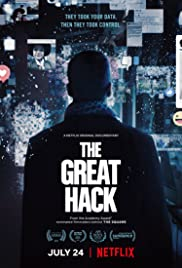

In [11]:
url = get_poster_img_link('tt9358204')
print(url)
Disp.Image(requests.get(url).content)

In [ ]:
TASK: get youtube urls for trailers
    using api, take a movie name, year, genre and get url of youtube trailer
    embed the video into website
    